$$
\newcommand{\fudm}[2]{\frac{\mathrm{D} #1}{\mathrm{D} #2}}
\newcommand{\pad}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\ppad}[2]{\frac{\partial^2 #1}{\partial #2^2}}
\newcommand{\ppadd}[3]{\frac{\partial^2 #1}{\partial #2 \partial #3}}
\newcommand{\nnabla}{\nabla^2}
\newcommand{\eps}{\epsilon}
\newcommand{\vdetail}[1]{\vb{#1}=\begin{pmatrix}#1_1\\#1_2\\#1_3\end{pmatrix}}
\newcommand{\vb}[1]{\mathbf{#1}}
\newcommand{\va}[1]{\vec{#1}}
\newcommand{\tb}[1]{\underline{\underline{\mathbf{#1}}}}
\newcommand{\fud}[2]{\frac{\mathrm{d} #1}{\mathrm{d} #2}}
$$

# Virtual Ultrasound Scanner

The program below allows to simulate a simple ultrasound phased arrat. Please make yourself aquainted with the options and try to get a strong reflect signal from the inhomogeneity. 

## Wave propagation in an inhomogeneous media

The wave equation in an inhomogeneous medium reads as

\begin{equation}
\frac{1}{\rho c^2}\ppad{p}{t}-\nabla \cdot \left(\frac{1}{\rho}(\nabla p)\right)=0
\end{equation}

\begin{equation}
\ppad{p}{t}=\rho c^2 \left( (\nabla \frac{1}{\rho}) \nabla p + \frac{1}{\rho} \nabla^2 p \right)
\end{equation}

Let us write this in two dimensions (x,y):

\begin{equation}
\ppad{p}{t}=c^2 \left[ -\frac{1}{\rho}\left(\pad{\rho}{x}\pad{p}{x}+\pad{\rho}{y}\pad{p}{y}\right) + \left( \ppad{p}{x}+\ppad{p}{y} \right) \right]
\end{equation}

We can write finite differences as:

\begin{equation}
p_{i,j}^{n+1}=2p_{i,j}^n-p_{i,j}^{n-1}+\\
\frac{(\Delta t)^2}{(\Delta x)^2} \left[ c_{i,j}^2 \left( p_{i-1,j}+p_{i+1,j}+p_{i,j-1}+p_{i,j+1}-4p_{i,j} \right)-
\frac{1}{4\rho_{i,j}} \left( \left(\rho_{i+1,j}-\rho_{i-1,j}\right)\left(p_{i+1,j}-p_{i-1,j}\right) + 
\left(\rho_{i,j+1}-\rho_{i,j-1}\right)\left(p_{i,j+1}-p_{i,j-1}\right)\right)
\right]
\end{equation}


#### Open Boundaries 
Small note, the algorithm allows for open boundaries, the wave is not refleced but passes without reflections the region of calculations. This behaviour is achieved by approximating the boundary with a plane wave radiating out of the volume, i.e. the boundary points fulfill the outgoing plane wave equation:

\begin{equation}
\vb{n}\cdot\nabla p + \frac{1}{c}\pad{p}{t}=0\quad ,
\end{equation}

where $\vb{n}$ is the normal vector. 

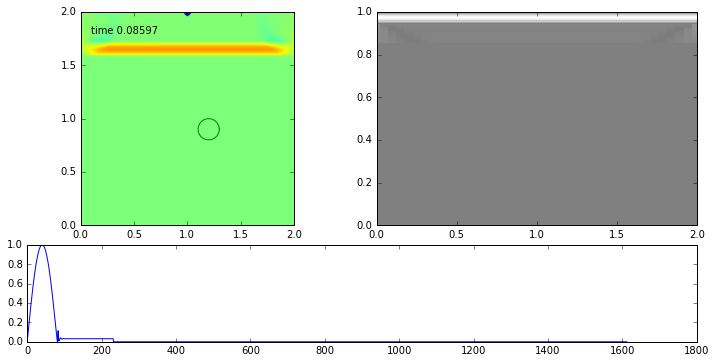

In [1]:
%matplotlib inline
import math as m
import numpy #array operations
import matplotlib.pyplot as plt #plotting
from matplotlib.collections import LineCollection
import matplotlib.colors as colors
from ipywidgets import widgets #for the widgets
from IPython import display #for continous display
#from PIL import Image #to export images

nimg=0

def calcu(un, unn, cc, rho, cconst):
    return 2.*un[1:-1,1:-1]-unn[1:-1,1:-1]+cconst*(cc[1:-1,1:-1]*\
        (un[:-2,1:-1]+un[2:,1:-1]+un[1:-1,:-2]+un[1:-1,2:]-4.*un[1:-1,1:-1])-\
        .25*rho[1:-1,1:-1]*((rho[2:,1:-1]-rho[:-2,1:-1])*(un[2:,1:-1]-un[:-2,1:-1])+\
        (rho[1:-1,2:]-rho[1:-1,:-2])*(un[1:-1,2:]-un[1:-1,:-2])))

def savemyimage(visual):
    global nimg
    visual = (visual +2.)/4.
    #result = Image.fromarray((visual * 255).astype(numpy.uint8))
    #result.save('out{:03d}.bmp'.format(nimg))
    nimg=nimg+1

def plotwave(u,time,pp,pt,d):
    plt.figure(1)
    plt.clf()
    
    #plot the pressue field
    plt.subplot2grid((4,4),(0,0), colspan = 2, rowspan = 2)
    plt.imshow(u, origin='upper', extent=[0., 2., 0., 2.], vmax=2, vmin=-2) #plot the wave field
    plt.text(0.1,1.8,"time {0:.5f}".format(time)) #annotate the time
    plt.plot(1.,w_probey.value,'o') #position of probe
    
    #draw position of inhomogenities
    phi=numpy.linspace(0.,2.*m.pi,20)
    for i in range(d.size):
        plt.plot(d['radius'][i]*numpy.cos(phi)+d['xpos'][i],2.-d['radius'][i]*numpy.sin(phi)-d['ypos'][i])
    plt.gca().set_xlim([0.,2.])
    plt.gca().set_ylim([0.,2.])
    
    #Plot all pressure sensor
    plt.subplot2grid((4,4),(0,2), colspan = 2, rowspan=2)
    gain_control=numpy.exp(pt*w_probegain.value)
    for i in range (pp.size):
        plotcolorline([pp['x'][i],1.],[pp['x'][i],0.],pp['s'][i]*gain_control,200)
    plt.gca().set_xlim([0,2.])
    
    #Phase corrected pressure
    plt.subplot2grid((4,4),(2,0), colspan = 4, rowspan=1)
    plt.plot(pp['s'][int(w_proben.value/2.)]*gain_control)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
#plot a line from startpos->endpos with signal colorcoded in n-strips
#example: plotcolorline([0,0],[2,2],numpy.linspace(0.,1.,10),10)
def plotcolorline(spos,epos,signal,n):
    nse=m.sqrt((epos[0]-spos[0])**2.+(epos[1]-spos[1])**2.)
    x=spos[0]+(epos[0]-spos[0])/nse*numpy.linspace(0.,1.,n)
    y=spos[1]+(epos[1]-spos[1])/nse*numpy.linspace(0.,1.,n)
    t = numpy.interp(numpy.linspace(0.,1.,n),numpy.linspace(0.,1.,signal.size),signal) 

    # set up a list of (x,y) points
    points = numpy.array([x,y]).transpose().reshape(-1,1,2)

    # set up a list of segments
    segs = numpy.concatenate([points[:-1],points[1:]],axis=1)

    # make the collection of segments
    lc = LineCollection(segs, cmap=plt.get_cmap('gray'), norm=colors.Normalize(-1., 1.), linewidth=10)
    lc.set_array(t) # color the segments by our parameter

    # plot the collection
    plt.gca().add_collection(lc) # add the collection to the plot
    plt.xlim(x.min(), x.max()) # line collections don't auto-scale the plot
    plt.ylim(y.min(), y.max())

def solvewave(b):
    #tabs.visible=False #make space for simulation
    #computational domain
    nx = ny = 381
    size=2. #size of the domain
    #parameters of the wave
    c = 5. #speed of sound of homogeneous me`dium 
    l=w_wavelength.value #wavelength
    nu=c/l #frequency
    omega=nu*2.*m.pi #angular frequency
    duration=w_sourceduration.value/nu #duration of source
    
    #position of source
    emissionlength=(w_sizeemit.value/100.)*nx
    startx=int(nx/2-emissionlength/2)
    endx=int(nx/2+emissionlength/2)

    #further variables
    dx = size/(nx-1)
    CFL=w_simcfl.value#CFL number < 1/sqrt(2)
    dt = CFL*dx/c 
    nt=int(w_simduration.value/dt) #number of time steps

    if w_sposition.value=='Top':
        sourcepos=0
    elif w_sposition.value=='Center':
        sourcepos=int(ny/2)
    else:
        sourcepos=ny-1

    #structured array for measuring the pressure at a position
    pt=numpy.arange(nt+1)*dt
    px=numpy.linspace(0.,2.,w_proben.value)
    pxi=(numpy.linspace(0.001,1.999,w_proben.value)/dx).astype(int)
    pp = numpy.zeros(w_proben.value, dtype=[('x','f4'),('xi','i4'),('s','f4',nt+1)])
    pp['x']=px
    pp['xi']=pxi

    #every xx times over the total nt timesteps an output should be generated 
    output=map(int,list(numpy.linspace(1,nt,int(nt*float(w_simoutput.value/100.)))))

    u  = numpy.zeros((nx,ny)) #pressure at t
    un = numpy.zeros((nx,ny)) #pressure at t-dt
    unn= numpy.zeros((nx,ny)) #pressure at t-2*dt

    #inhomogeneous speed of sound c**2 !
    cc = numpy.ones((nx,ny))
    #inhomogeneous density
    rho = numpy.ones((nx,ny))  

    #build some inhomgeneous medium
    if w_ikind.value=="Random":
        nd=int(w_inumber.value)
        d=numpy.zeros(nd,dtype={'names':['radius','xpos','ypos'],'formats':['f8','f8','f8']})
        #d['radius']=numpy.random.rand(nd)*.2
        d['radius']=numpy.ones(nd)*.1
        d['xpos']=numpy.random.rand(nd)*2.
        d['ypos']=numpy.random.rand(nd)+1.
    else:
        nd=1
        d=numpy.zeros(nd,dtype={'names':['radius','xpos','ypos'],'formats':['f8','f8','f8']})
        d['radius']=numpy.ones(nd)*.1
        d['xpos']=numpy.ones(nd)*1.2
        d['ypos']=numpy.ones(nd)+.1
    xx,yy=numpy.meshgrid(numpy.linspace(0,2.,nx),numpy.linspace(0,2.,nx))
    for i in range(d.size):
        a=numpy.where((xx-d['xpos'][i])**2+(yy-d['ypos'][i])**2<(d['radius'][i]**2))
        cc[a]=3.
        rho[a]=3.    
    cc=cc*c*c
    
    #set the phase for send beamforming
    phaselin=(numpy.linspace(startx*dx,endx*dx,endx-startx)-1.)/c*m.tan(float(w_sangle.value)*m.pi/180.)
    #half the aperture
    a=(endx-startx)/2.*dx
    #focus distance
    R=w_sradius.value
    #spherical phase with x being the distance from the center: R-sqrt(R^2-a^2+x^2)
    if (w_sradiuschk.value):
        phasesph=(R-numpy.sqrt(R*R-a*a+(numpy.linspace(startx*dx,endx*dx,endx-startx)-1)**2.))/c
    else:
        phasesph=0.
    phase=phaselin+phasesph
    phasetot=(phase.max()-phase.min())
    phasemin=phase.min()
    yreceive_pos=int((2.-w_probey.value)*(nx-1)/2.)
    
    plt.figure(1, figsize=(12, 8), dpi=300)

    for n in range(nt+1): ##loop across number of time steps

        #here we compute the wave propagation in an inhomogeneous media using Cython (to speed up things)
        u[1:-1,1:-1]=calcu(un,unn,cc,rho,dt*dt/dx/dx)

        #Impose the boundary conditions                 
        if w_nbc.value=='Open':
            u[0,:] = -dx/dt/(cc[0,:]**.5)*(u[1,:]-un[1,:])+u[1,:]
        else:
            u[0,:] = u[1,:]
        if w_sbc.value=='Open':
            u[-1,:] = -dx/dt/(cc[-1,:]**.5)*(u[-2,:]-un[-2,:])+u[-2,:]
        else:
            u[-1,:] = u[-2,:]
        if w_wbc.value=='Open':
            u[:,0] = -dx/dt/(cc[:,0]**.5)*(u[:,1]-un[:,1])+u[:,1]
        else:
            u[:,0] = u[:,1]
        if w_ebc.value=='Open':
            u[:,-1] = -dx/dt/(cc[:,-1]**.5)*(u[:,-2]-un[:,-2])+u[:,-2]
        else:
            u[:,-1] = u[:,-2]
        
        #pressure source
        if n*dt<(duration+phasetot+2*dt):
            #generate a source with the correct phase and duration of each phase
            usource=numpy.sin(omega*(n*dt-phase+phasemin))*\
                    ((n*dt+phasemin)>phase)*((n*dt+phasemin)<phase+duration)
            if w_sorientation.value=='Horizontal':
                u[sourcepos,startx:endx]=usource
            else:
                u[startx:endx,sourcepos]=usource
            
        #Save pressures at the probe locations
        pp['s'][:,n]=u[yreceive_pos,pp['xi'][:]]
        #save values for the time derivative 
        unn=un.copy() #n-1 time steop
        un=u.copy()   #n time step
        
        if (n in output):
            plotwave(u,n*dt,pp,pt,d)
            if (w_saveplots.value):
                savemyimage(u)
            
    #and plot the last figure    
    #plotwave(u,n*dt,pp,pt,d)
    #tabs.visible=True #open menue
    
#setup the graphical interface 
w_wavelength=widgets.FloatSlider(description="Wavelength",value=.3,min=0.1,max=1)
w_sizeemit=widgets.FloatSlider(description="Emitter Size in (%)",value=100,min=1,max=100)
w_sourceduration=widgets.FloatSlider(description="Emission Duration in Periods",value=.5,min=0.5,max=10)
w_simcfl=widgets.FloatSlider(description="CFL Number",value=.5*1./m.sqrt(2.),min=0.01,max=1./m.sqrt(2.))
w_simduration=widgets.FloatSlider(description="Simulation Duration",value=.6,min=0.1,max=10)
w_simoutput=widgets.FloatSlider(description="Output % of timesteps",value=.5,min=.1,max=10)
w_saveplots=widgets.Checkbox(description="Save Images",value=False)
w_sposition=widgets.RadioButtons(description="Source Position",\
                                 options=["Top", "Center", "Bottom"],value="Top",margin=10)
w_sorientation=widgets.RadioButtons(description="Source Orientation",options=["Horizontal", "Vertical"],\
                                    value="Horizontal",margin=10)
w_sangle=widgets.IntSlider(description="Angle",value=0,min=-30,max=30)
w_sradiuschk=widgets.Checkbox(description="Spherical Focus",value=False)
w_sradius=widgets.FloatSlider(description="Radius",value=1.5,min=0.5,max=5.)
w_nbc=widgets.RadioButtons(description="North B.C.",options=["Reflective", "Open"],value="Open",margin=10)
w_sbc=widgets.RadioButtons(description="South B.C.",options=["Reflective", "Open"],value="Open",margin=10)
w_wbc=widgets.RadioButtons(description="West B.C.",options=["Reflective", "Open"],value="Open",margin=10)
w_ebc=widgets.RadioButtons(description="East B.C.",options=["Reflective", "Open"],value="Open",margin=10)
w_ikind=widgets.RadioButtons(description="Kind",options=["Fixed","Random"],value="Fixed",margin=10)
w_inumber=widgets.IntSlider(description="Number",value=1,min=0,max=20,margin=10)
w_probey=widgets.FloatSlider(description="Probe Position",value=2.,min=0.,max=2.)
w_proben=widgets.IntSlider(description="Number of Probes",value=40,min=3,max=50)
w_probegain=widgets.FloatSlider(description="Gain Control",value=0.,min=0.,max=10.)
page1=widgets.VBox([widgets.VBox([w_wavelength,w_sizeemit,w_sourceduration]),\
                    widgets.HBox([w_sposition,w_sorientation,\
                                  widgets.VBox([w_sangle,\
                                    widgets.HBox([w_sradiuschk,w_sradius])])])])
page2=widgets.Box([w_simcfl,w_simduration,w_simoutput])
page3=widgets.Box([w_saveplots,w_probey,w_proben,w_probegain])
page4=widgets.HBox([w_nbc,w_sbc,w_wbc,w_ebc])
page5=widgets.HBox([w_ikind,w_inumber])
tabs = widgets.Tab(children=[page1, page2, page3, page4, page5])
tabs.set_title(0, 'Source')
tabs.set_title(1, 'Simulation')
tabs.set_title(2, 'Record')
tabs.set_title(3, 'Boundary Conditions')
tabs.set_title(4, 'Inhomogenities')
w_start=widgets.Button(description="Start Simulation",margin=10)
w_start.on_click(solvewave)
display.display(tabs)
display.display(w_start)   

# Hallo